<a href="https://colab.research.google.com/github/seong576/nystagmus_detection/blob/main/Retinal_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Retina Detection in Image 

## Image To Numpy

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob


path = "/content/drive/MyDrive/retina/"

img_list = sorted(glob.glob(path+'8_hrl,180/*.jpg'))
mask_list = sorted(glob.glob(path+'8_hrl,180_mask/*.png'))
row_size =320
col_size = 320

x_data, y_data = np.empty((2, len(img_list), row_size, col_size , 1), dtype=np.float32)

for i, img_path in enumerate(img_list):
    img = imread(img_path)
    img = resize(img, output_shape=(row_size, col_size , 1), preserve_range=True)
    x_data[i] = img
      
for i, img_path in enumerate(mask_list):
    img = imread(img_path)
    img = resize(img, output_shape=(row_size, col_size , 1), preserve_range=True)
    y_data[i] = img
    
y_data /= 255.

fig, ax = plt.subplots(1, 2)
ax[0].imshow(x_data[12].squeeze(), cmap='gray')
ax[1].imshow(y_data[12].squeeze(), cmap='gray')


x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1,shuffle=True)

np.save(path+'x_train.npy', x_train)
np.save(path+'y_train.npy', y_train)
np.save(path+'x_val.npy', x_val)
np.save(path+'y_val.npy', y_val)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

##U-net Model

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from __future__ import print_function
import cv2
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, concatenate, Dropout, Conv2D, Conv3D
from keras.layers import MaxPooling2D, MaxPooling3D, Conv2DTranspose, UpSampling2D
from keras.layers import BatchNormalization, Activation
from keras.layers import Reshape, Dense, multiply, Add, Concatenate
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import models
from keras import callbacks
from keras.layers import Input, Activation, Conv2D, Flatten, Dense, MaxPooling2D, Dropout, Add, LeakyReLU, UpSampling2D
from keras.models import Model, load_model
from keras.callbacks import ReduceLROnPlateau

path = "/content/drive/MyDrive/retinal/"

x_train = np.load(path+'x_train.npy')
y_train = np.load(path+'y_train.npy')
x_val = np.load(path+'x_val.npy')
y_val = np.load(path+'y_val.npy')
smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)


inputs = Input(shape=(320, 320, 1))

conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
batch1 = BatchNormalization()(conv1) 
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(batch1)
drop1 = tf.keras.layers.Dropout(0.1)(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)


conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
batch2 = BatchNormalization()(conv2) 
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(batch2)
drop2 = tf.keras.layers.Dropout(0.1)(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)


conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
batch3 = BatchNormalization()(conv3) 
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(batch3)
drop3 = tf.keras.layers.Dropout(0.1)(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
batch4 = BatchNormalization()(conv4) 
conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(batch4)
drop4 = tf.keras.layers.Dropout(0.1)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
batch5 = BatchNormalization()(conv5) 
conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(batch5)
drop5 = tf.keras.layers.Dropout(0.1)(conv5)

up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2),
                                       padding='same')(conv5), conv4], axis=3)
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
batch6 = BatchNormalization()(conv6) 
conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(batch6)

up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2),
                                       padding='same')(conv6), conv3], axis=3)
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
batch7 = BatchNormalization()(conv7) 
conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(batch7)

up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2),
                                       padding='same')(conv7), conv2], axis=3)
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
batch8 = BatchNormalization()(conv8) 
conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(batch8)

up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2),
                                       padding='same')(conv8), conv1], axis=3)
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
batch9 = BatchNormalization()(conv9) 
conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(batch9)

conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)
model = Model(inputs=[inputs], outputs=[conv10])
model.compile(optimizer=Adam(learning_rate=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

model_checkpoint = ModelCheckpoint('unet.hdf5', monitor='loss', save_best_only=True)

history = model.fit(x_train, y_train, batch_size=6, epochs=20,
                        verbose=1, shuffle=True,
                        validation_data=(x_val, y_val),callbacks=[model_checkpoint])

model.save(path+"Unet")

##Video to Numpy and Prediction

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import sys
from google.colab.patches import cv2_imshow
import scipy.misc
path = "/content/drive/MyDrive/retina/"
model = keras.models.load_model(path+"Unet", compile =False)

cap = cv2.VideoCapture(path+"dhl.mp4")
tensor = []
while cap.isOpened():
    ret, image = cap.read()

    if not ret:
        break
    image = cv2.resize(image, (320, 320))
    gray_img = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    tensor.append(np.asarray(gray_img)[:,:])
    cv2.waitKey(0)

tensor = np.array(tensor)
cv2.destroyAllWindows()
cap.release()

x_test = np.asarray(np.load(path+"x_train.npy"),dtype="uint8")
#preds = np.asarray(np.load(path+"y_train.npy"),dtype="uint8")
#x_test = np.asarray(tensor,dtype="uint8")
preds = np.asarray(model.predict(x_test),dtype="uint8")

img_rows =120
img_cols =320
def set_view():
    total=x_test.shape[0]
    img = np.ndarray((total, img_rows, img_cols), dtype=np.uint8)
    mask = np.ndarray((total, img_rows, img_cols), dtype=np.uint8)
    kernel = np.ones((3, 3), np.uint8)
    dst = np.full((total,img_rows, img_cols),255,dtype=np.uint8)
    img = x_test
    mask = preds
    print("total time : {0:0.2f}".format(total/30))
    for m in range(total):
        msk = cv2.dilate(mask[m], kernel, iterations=1)
        msk = cv2.GaussianBlur(msk, (0,0), 7)
        cv2.copyTo(img[m],msk,dst[m])
    return dst

view_imgs = np.ndarray((x_test.shape[0],img_rows, img_cols), dtype=np.uint8)
view_imgs = set_view()
for i in range(20):
    #left.write(view_imgs[i,:320,160:])
    #_,inv_img = cv2.threshold(view_imgs[i,:,:],160,255,cv2.THRESH_TOZERO_INV|cv2.THRESH_BINARY)
    cv2_imshow(x_test[i,:,:])
    cv2_imshow(view_imgs[i,:,:])
    #right.write(view_imgs[i,:320,160:])

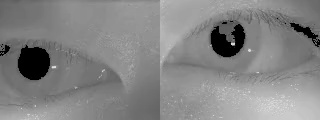

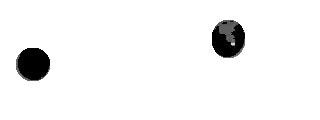

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
path = "/content/drive/MyDrive/retinal/"
model = keras.models.load_model(path+"Unet", compile =False)

msk = np.asarray(cv2.imread(path+"Train_Mask/1.png",cv2.IMREAD_GRAYSCALE),dtype="uint8")
img = cv2.imread(path+"Train_img/1.jpg",cv2.IMREAD_GRAYSCALE)
x = np.ones((120,320),dtype="uint8")*255
cv2_imshow(img)

cv2.copyTo(img,msk,x)
cv2_imshow(x)


#Nystagmus Detection 

##Make DataSet To Numpy
 * processing for Convlstm Input

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.io import imread
from skimage.transform import pyramid_reduce, resize
import os, glob
from sklearn.preprocessing import LabelEncoder

path = "/content/drive/MyDrive/sample/"

row_size =60
col_size = 160
classes = ["fixed", "move"]

def frames_extraction_and_create(video_path):
    frames_list = []
    X = []
    Y = []
    classes_list = os.listdir(video_path)
    print(classes_list)
    for c in classes_list: #nystagmus, runout
        files_list = os.listdir(os.path.join(path,c))
        for files in files_list: # 45,46,51....
          file_img = os.listdir(os.path.join(path,c+"/"+files))
          for segment in file_img: #334.jpg 335.jpg
              if segment.find("jpg") != -1:
                  image = cv2.imread(os.path.join(path,c+"/"+files+"/"+segment),cv2.IMREAD_GRAYSCALE)
                  image = cv2.resize(image,dsize=(col_size,row_size),interpolation=cv2.INTER_AREA)
                  frames_list.append(image)
          X.append(frames_list)
          frames_list = []
          if c.find(classes[0]) != -1:
              Y.append([0,1])
          else:
              Y.append([1,0])
    
    df = pd.DataFrame(data = Y,columns=[classes[0],classes[1]])
    X=np.asarray(X)
    return X,df.to_numpy()

X,Y=frames_extraction_and_create(path)

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.1,shuffle=True)

np.save(path+'x_train.npy', x_train)
np.save(path+'y_train.npy', y_train)
np.save(path+'x_val.npy', x_val)
np.save(path+'y_val.npy', y_val)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)


['move', 'fixed']
(306, 15, 60, 160) (306, 2)
(34, 15, 60, 160) (34, 2)


In [ ]:
import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
 
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix

data_dir = "/content/drive/MyDrive/sample/"
img_height , img_width = 120, 320
 
classes = ["fixed", "move"]

def load_data(path):
  x_train = np.load(path+'x_train.npy',allow_pickle=True)
  y_train = np.load(path+'y_train.npy',allow_pickle=True)
  x_test = np.load(path+'x_val.npy',allow_pickle=True)
  y_test = np.load(path+'y_val.npy',allow_pickle=True)
  print(x_train.shape)
  return x_train,x_test,y_train,y_test

def get_Model():
  inp = keras.layers.Input(shape=(15,60,160,1))

  x = keras.layers.ConvLSTM2D(filters=64,kernel_size=(5, 5),return_sequences=True,activation="tanh")(inp)
  x = keras.layers.MaxPooling3D(pool_size = (1,5,5),padding ='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.ConvLSTM2D(filters=64,kernel_size=(3, 3),return_sequences=True,activation="tanh")(x)
  x = keras.layers.MaxPooling3D(pool_size = (1,3,3),padding ='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.ConvLSTM2D(filters=64,kernel_size=(1, 1),return_sequences=True,activation="tanh")(x)
  x = keras.layers.MaxPooling3D(pool_size = (1,3,3),padding ='same')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.Dropout(0.2)(x)

  x = keras.layers.Flatten()(x)
  x = keras.layers.Dense(256,activation = "relu")(x)
  x = keras.layers.Dense(2,activation = "softmax")(x)

  model = keras.models.Model(inp, x)
  opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
  model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer=opt, metrics=["accuracy"])
  model.summary()
  return model

model = get_Model()
x_train, x_test, y_train, y_test = load_data(data_dir)

earlystop = EarlyStopping(patience=7)
callbacks = [earlystop]
early_stopping = keras.callbacks.EarlyStopping(monitor="loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 5
batch_size = 8

# Fit the model to the training data.
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=[early_stopping, reduce_lr],
)

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 15, 60, 160, 1)]  0         
                                                                 
 conv_lstm2d_26 (ConvLSTM2D)  (None, 15, 56, 156, 64)  416256    
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 15, 12, 32, 64)   0         
 g3D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 15, 12, 32, 64)   256       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 15, 12, 32, 64)    0         
                                                                 
 conv_lstm2d_27 (ConvLSTM2D)  (None, 15, 10, 30, 64)   2951